# About skills_detector.ipynb

This notebook detects skills in log files suchs as CVS.
This is a work in progress :)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages

# Build super basic detectors
We want to know who uses tables and graphs. period.

In [34]:
def get_use_table(df):
    tables = set(df['Table'])
    for i,t in enumerate(tables):
        table = read_table(t)
        if len(table)>0:
            return 1
    return 0

def get_use_graph(df):
    tables = set(df['Table'])
    for i,t in enumerate(tables):
        table = read_table(t)
        points = get_pts(table,in_graph=True) #grab all points
        if len(points)>0:
            return 1
    return 0

# Build dectectors
## Quantitative CVS
### In table
First we extract all of their tables at all time points, analyze them for CVS and find the maximum number of values of a variable that was part of a control variable strategy instance.
For now, use of this skill relies on the following production rules (evaluated per variable):

* more than 2 successive records were done where only the variable was changed
* the outcome variable was different for both data points
* battery connected (caps)
* laser is on (beers)


In [2]:
def get_outcome_values(pts):
    outcomes = []
    for pt in pts:
        if "Charge" in pt.keys():
            outcomes.append(pt["Charge"])
        elif "Absorbance" in pt.keys():
            outcomes.append(pt["Absorbance"])
        else:
            print "OUTCOME MISSING"
    return outcomes

def find_intervals(values):
    #take lngest set of values
    longest_values = {k:max(v,key=len) for k,v in values.iteritems()}
    
    #keep only if three or more values
    long_enough_values = {k:v if len(v)>2 else [] for k,v in longest_values.iteritems()}
    #convert to set, then list, then sort it.
    cvs_values = {k:sorted(list(set(v))) for k,v in long_enough_values.iteritems()}
    
    #find distance between all points
    distances = {k:[v2 - v1 for v1,v2 in zip(vs, vs[1:])] for k,vs in cvs_values.iteritems()}
    
    #check if distances are all the same or not
    intervals = {k:True if len(set(ds))==1 else False for k,ds in distances.iteritems()}
    return intervals
    
    

def detect_cvs_quant_in_table(table):
    cvs_variable = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}
    cvs_values = {"Battery voltage":[[]],
                        "Area":[[]],
                        "Separation":[[]],
                        "Width":[[]],
                        "Wavelength":[[]],
                        "Concentration":[[]]}
    variable_changed = None
    new_var_changed = None
    number_of_changes = 1
    prev_point = None
    #data points in order of trial number, which is synonomous with 
    #order of capture since when you move data points around in the table,
    #they keep the same trial number
    for datapoint in sorted(table.iterkeys()): 
        curr_point = table[datapoint]
        if prev_point:
            values_of_2_points = get_values_per_variable([prev_point,curr_point])
#             print values_of_2_points['Width']
            confounded = pts_are_confounded(values_of_2_points)
            outcomes = get_outcome_values([prev_point,curr_point])
            outcome1,outcome2 = outcomes[0],outcomes[1]
            #we check that only one variable is changed (confounded = False)
            # that the laser was not off, and that the connection wasn't to lightbulb
            # and that the outcome values are not null but floats
            if not confounded and 0 not in values_of_2_points["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values_of_2_points["Connection"] and isinstance(outcome1, float) and isinstance(outcome2, float):
                #find the variable being changed
                for v,vals in values_of_2_points.iteritems():
                    if len(vals) > 1:
                        new_var_changed = v
                if new_var_changed == None:
                    pass
                #update the number of changes for that variable
                if variable_changed == None or new_var_changed == variable_changed:
                    number_of_changes += 1
                else:
                    for k in cvs_values.keys():
                        if cvs_values[k][-1]!=[]: cvs_values[k].append([])
                    number_of_changes = 2
                variable_changed = new_var_changed
                if variable_changed in cvs_variable.keys(): #ignore cvs on detector, lightbulba nd connection
                    cvs_variable[variable_changed] = max(number_of_changes,cvs_variable[variable_changed])
                    cvs_values[variable_changed][-1].extend(values_of_2_points[variable_changed])
#                     print cvs_values
            else:
                number_of_changes = 1
                variable_changed = None
        prev_point = curr_point.copy()
    
    cvs_intervals = find_intervals(cvs_values)
    return cvs_variable, cvs_intervals
            
            
def get_cvs_per_variable_in_table(df):
    tables = set(df['Table'])
    cvs_final = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}
    intervals_final = {"Battery voltage":False,
                        "Area":False,
                        "Separation":False,
                        "Width":False,
                        "Wavelength":False,
                        "Concentration":False}
    for i,t in enumerate(tables):
        table = read_table(t) #converts json string to dictionary
#         print table
        #since many of their tables have CVS, we want to largest sample size for a variable used in CVS
        cvs,intervals = detect_cvs_quant_in_table(table)
        cvs_final = {k:max(v,cvs[k]) for k,v in cvs_final.iteritems()}
        intervals_final = {k:max(v,intervals[k]) for k,v in intervals_final.iteritems()}
    return cvs_final,intervals_final

Testing intervals

In [3]:
beers_in_2_on = '''{
    "1": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 4, "trialNumber": 1, "Absorbance": 0.04, "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 1},     
    "2": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 4, "trialNumber": 2, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 100.0, "Laser toggle": 1},
    "3": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1, "trialNumber": 3, "Absorbance": 0.04, "Wavelength": 582, "Concentration": 100.0, "Laser toggle": 1},
    "4": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 2, "trialNumber": 4, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 100.0, "Laser toggle": 1},
    "5": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 3, "trialNumber": 5, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 100.0, "Laser toggle": 1},
    "6": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 3, "trialNumber": 6, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 300.0, "Laser toggle": 1}}'''
_, intervals = detect_cvs_quant_in_table(read_table(beers_in_2_on))
print intervals =={'Battery voltage': False, 'Area': False, 'Width': True, 'Separation': False, 'Wavelength': False, 'Concentration': False}

True


### In graph
First we extract all of their tables at all time points, keep only points in the tables that are visible in the graph, analyze them for CVS and find the maximum number of values of a variable that was part of a control variable strategy instance.
For now, use of this skill relies on the following rules (evaluated per variable):
* more than records where only the variable was changed are in the graph
* battery connected (caps)
* laser is on (beers)


In [4]:
convert_axis = {"Absorbance":"absorbance","Concentration":"concentration","Width":"cuvetteWidth","Wavelength":"trialNumber","Battery voltage":"trialNumber","Area":"area","Separation":"separation","Charge":"charge"}
def detect_cvs_quant_in_graph(table,x_axis,y_axis):
    points = get_pts(table,in_graph=True) #grab all points
    cvs_variable = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}
    #check that outcome variable as one of the axes
    
    if x_axis not in ["charge","absorbance"] and y_axis not in ["charge","absorbance"]:
        return cvs_variable,{}
    
    values = get_values_per_variable(points)
    confounded = pts_are_confounded(values)
    if not confounded and 0 not in values["Laser toggle"] and "LIGHT_BULB_CONNECTED" not in values["Connection"]:
        #find the variable being changed
        for v,vals in values.iteritems():
            if len(vals) > 1:
                #check that variable being varied is in one of the axes
                if convert_axis[v] in [x_axis,y_axis]:
                    cvs_variable[v] = len(vals)
                    return cvs_variable,{}
    return cvs_variable,{}
    
            
            
            
def get_cvs_per_variable_in_graph(df):
#     tables = df['Table'])
    tables_with_axes = set(zip(df['Table'], df['X axis'], df['Y axis']))
    cvs_final = {"Battery voltage":0,
                        "Area":0,
                        "Separation":0,
                        "Width":0,
                        "Wavelength":0,
                        "Concentration":0}
    for t,x_axis,y_axis in tables_with_axes:
        table = read_table(t)
        cvs_final = {k:max(v,detect_cvs_quant_in_graph(table,x_axis,y_axis)[k]) for k,v in cvs_final.iteritems()}
#         print cvs_final
#         print '\n'
    return cvs_final

### Test CVS detector for different scenarios
If all return True, we are good to go

In [5]:
beers_in_1_on = '''{
    "1": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1.3, "trialNumber": 1, "Absorbance": 0.04, "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 1},     
    "2": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 2.0, "trialNumber": 2, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 1}}'''
beers_out_1_on = {'Battery voltage': 0, 'Area': 0, 'Width': 2, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "table",beers_out_1_on == detect_cvs_quant_in_table(read_table(beers_in_1_on))[0]
print "graph",beers_out_1_on == detect_cvs_quant_in_graph(read_table(beers_in_1_on),"absorbance","cuvetteWidth")[0]
beers_out_1_on = {'Battery voltage': 0, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "graph",beers_out_1_on == detect_cvs_quant_in_graph(read_table(beers_in_1_on),"concentration","absorbance")[0]

beers_in_1_off = '''{
    "1": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1.3, "trialNumber": 1, "Absorbance": "nan", "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 0},     
    "2": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1.3, "trialNumber": 2, "Absorbance": "nan", "Wavelength": 582, "Concentration": 100.0, "Laser toggle": 0}}'''
beers_out_1_off = {'Battery voltage': 0, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "table",beers_out_1_off == detect_cvs_quant_in_table(read_table(beers_in_1_off))[0]
print "graph",beers_out_1_off == detect_cvs_quant_in_graph(read_table(beers_in_1_off),"concentration","cuvetteWidth")[0]

beers_in_2_on = '''{
    "1": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1.3, "trialNumber": 1, "Absorbance": 0.04, "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 1},     
    "2": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1.3, "trialNumber": 2, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 100.0, "Laser toggle": 1},
    "3": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1, "trialNumber": 3, "Absorbance": 0.04, "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 1},
    "4": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 2, "trialNumber": 4, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 1}}'''
beers_out_2_on_table = {'Battery voltage': 0, 'Area': 0, 'Width': 2, 'Separation': 0, 'Wavelength': 0, 'Concentration': 2}
beers_out_2_on_graph = {'Battery voltage': 0, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "table",beers_out_2_on_table == detect_cvs_quant_in_table(read_table(beers_in_2_on))[0]
print "graph",beers_out_2_on_graph == detect_cvs_quant_in_graph(read_table(beers_in_2_on),"concentration","cuvetteWidth")[0]

beers_in_1_on_off = '''{
    "1": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1.3, "trialNumber": 1, "Absorbance": 0.04, "Wavelength": 582, "Concentration": 200.0, "Laser toggle": 0},     
    "2": {"Ruler location": {"y": 3.62, "x": 3.28}, "Detector location": {"y": 2.0, "x": 6.67}, "visible": true, "Width": 1.3, "trialNumber": 2, "Absorbance": 0.02, "Wavelength": 582, "Concentration": 100.0, "Laser toggle": 1}}'''
beers_out_1_on_off = {'Battery voltage': 0, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "table",beers_out_1_on_off == detect_cvs_quant_in_table(read_table(beers_in_1_on_off))[0]
print "graph",beers_out_1_on_off == detect_cvs_quant_in_graph(read_table(beers_in_1_on_off),"concentration","cuvetteWidth")[0]

caps_in_1_battery = '''{
    "1": {"Battery voltage": -1.5, "Area": 100.0, "Connection": "BATTERY_CONNECTED", "Capacitor voltage": -1.5, "visible": true, "Charge": -0.13, "trialNumber": 1, "Separation": 10.0}, 
    "2": {"Battery voltage": 0.3923, "Area": 100.0, "Connection": "BATTERY_CONNECTED", "Capacitor voltage": 0.3923, "visible": true, "Charge": 0.03, "trialNumber": 2, "Separation": 10.0}}'''
caps_out_1_battery = {'Battery voltage': 2, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "table",caps_out_1_battery == detect_cvs_quant_in_table(read_table(caps_in_1_battery))[0]
print "graph",caps_out_1_battery == detect_cvs_quant_in_graph(read_table(caps_in_1_battery),"trialNumber","charge")[0]
caps_out_1_battery = {'Battery voltage': 0, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "graph",caps_out_1_battery == detect_cvs_quant_in_graph(read_table(caps_in_1_battery),"trialNumber","area")[0]


caps_in_1_lightbulb = '''{
    "1": {"Battery voltage": -1.5, "Area": 100.0, "Connection": "LIGHT_BULB_CONNECTED", "Capacitor voltage": -1.5, "visible": true, "Charge": -0.13, "trialNumber": 1, "Separation": 10.0}, 
    "2": {"Battery voltage": 0.3923, "Area": 100.0, "Connection": "LIGHT_BULB_CONNECTED", "Capacitor voltage": 0.3923, "visible": true, "Charge": 0.03, "trialNumber": 2, "Separation": 10.0}}'''
caps_out_1_lightbulb = {'Battery voltage': 0, 'Area': 0, 'Width': 0, 'Separation': 0, 'Wavelength': 0, 'Concentration': 0}
print "table",caps_out_1_lightbulb == detect_cvs_quant_in_table(read_table(caps_in_1_lightbulb))[0]
print "graph",caps_out_1_lightbulb == detect_cvs_quant_in_graph(read_table(caps_in_1_lightbulb),"trialNumber","charge")[0]

table True
graph True
graph True
table True
graph True
table True
graph True
table True
graph True
table True
graph True
graph True
table True
graph True


# Let's run the detector on all students...
Since we don't yet have a metadata file to pull the right log data per student (and ingore student id that were test runs or unusable student data) were going to run the detector on all student ids have exactl one log file for each sims (~150).

In [8]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

## basic detectors first

In [35]:
ids = get_students_to_analyze_log()
use_wrapper_df = pd.DataFrame(index =ids, columns = ['use_table', 'use_graph'])
use_wrapper_df = use_wrapper_df.fillna(0)
use_wrapper_df.index.name = 'studentid'
for c in use_wrapper_df.columns:
    use_wrapper_df[[c]] = use_wrapper_df[[c]].astype(int)
use_wrapper_df[use_wrapper_df.index==17729162]

,use_table,use_graph
studentid,,
17729162,0,0


In [39]:
 wrapper_all_logs = {'use_table':0,'use_graph':0}
    
%aimport utils_read_parsing
for sim in ['beers','capacitor']:
    log_files = log_files_per_sim[sim]
    for sid,logs in log_files.iteritems():
#         if sid != 17729162:
#             continue
        wrapper_all_logs = {'use_table':0,'use_graph':0}
        for log in logs:
            df = prep_parsing_data(log)
            if not df.empty:
                #we find the instances of CVS in this log file
                use_table = get_use_table(df)
                use_graph = get_use_graph(df)
#                 print sim, use_table, use_graph
                #we append them to a summary cvs
                wrapper_all_logs['use_table'] = max(wrapper_all_logs['use_table'],use_table)
                wrapper_all_logs['use_graph'] = max(wrapper_all_logs['use_graph'],use_graph)
#                 print wrapper_all_logs

            else:
                print sid, log

        for var, usage in wrapper_all_logs.iteritems():
            if usage>0:
                use_wrapper_df.set_value(sid, var, usage)

In [43]:
use_wrapper_df.to_csv('use_wrapper_results.txt', sep='\t')

## Serious detectors

In [38]:
ids = get_students_to_analyze_log()
table_cvs_df = pd.DataFrame(index =ids, columns = ['Battery voltage', 'Area', 'Separation','Wavelength','Width', 'Concentration'])
table_cvs_df = table_cvs_df.fillna(0)
table_cvs_df.index.name = 'studentid'
for c in table_cvs_df.columns:
    table_cvs_df[[c]] = table_cvs_df[[c]].astype(int)
graph_cvs_df = table_cvs_df.copy()
table_intervals_df = table_cvs_df.copy()
for c in table_intervals_df.columns:
    table_intervals_df[[c]] = table_intervals_df[[c]].astype(bool)
table_intervals_df.head()

,Battery voltage,Area,Separation,Wavelength,Width,Concentration
studentid,,,,,,
11612162,False,False,False,False,False,False
13660166,False,False,False,False,False,False
41947147,False,False,False,False,False,False
64006159,False,False,False,False,False,False
15749160,False,False,False,False,False,False


In [39]:
%aimport utils_read_parsing
for sim in ['beers','capacitor']:
    log_files = log_files_per_sim[sim]
    for sid,logs in log_files.iteritems():
#         if sid == 10866146:
        cvs_all_logs_table = {"Battery voltage":0,"Area":0,"Separation":0,"Width":0,"Wavelength":0,"Concentration":0}
        cvs_all_logs_graph = {"Battery voltage":0,"Area":0,"Separation":0,"Width":0,"Wavelength":0,"Concentration":0}
        intervals_all_logs_table = {"Battery voltage":False,"Area":False,"Separation":False,"Width":False,"Wavelength":False,"Concentration":False}
        #for each log file
#         print sim, sid, len(logs)
        for log in logs:
            df = prep_parsing_data(log)
            if not df.empty:
                #we find the instances of CVS in this log file
                cvs_table,intervals_table = get_cvs_per_variable_in_table(df)
#                 cvs_graph = get_cvs_per_variable_in_graph(df)
                #we append them to a summary cvs
                intervals_all_logs_table = {k:max(v,intervals_table[k]) for k,v in intervals_all_logs_table.iteritems()}
#                 cvs_all_logs_table = {k:max(v,cvs_table[k]) for k,v in cvs_all_logs_table.iteritems()}
#                 cvs_all_logs_graph = {k:max(v,cvs_graph[k]) for k,v in cvs_all_logs_graph.iteritems()}
            else:
                print sid, log
        #now we save to the data to our mega df
#         for var, n_samples in cvs_all_logs_table.iteritems():
#             if n_samples >0:
#                 table_cvs_df.set_value(sid, var, n_samples)
#         for var, n_samples in cvs_all_logs_graph.iteritems():
#             if n_samples >0:
#                 graph_cvs_df.set_value(sid, var, n_samples)
        for var, used_intervals in intervals_all_logs_table.iteritems():
            if used_intervals:
                table_intervals_df.set_value(sid, var, used_intervals)

In [40]:
# table_cvs_df.to_csv('table_cvs_results.txt', sep='\t')
table_intervals_df.to_csv('table_intervals_results.txt', sep='\t')
# graph_cvs_df.to_csv('graph_cvs_results.txt', sep='\t')

In [79]:
table_intervals_df = table_intervals_df[['Battery voltage', 'Area', 'Separation','Wavelength','Width', 'Concentration']]
table_intervals_df.shape

(148, 6)

In [72]:
table_intervals_df['count'] = table_intervals_df.select_dtypes(include=['bool']).sum(axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012747D68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000013B5EF60>]], dtype=object)

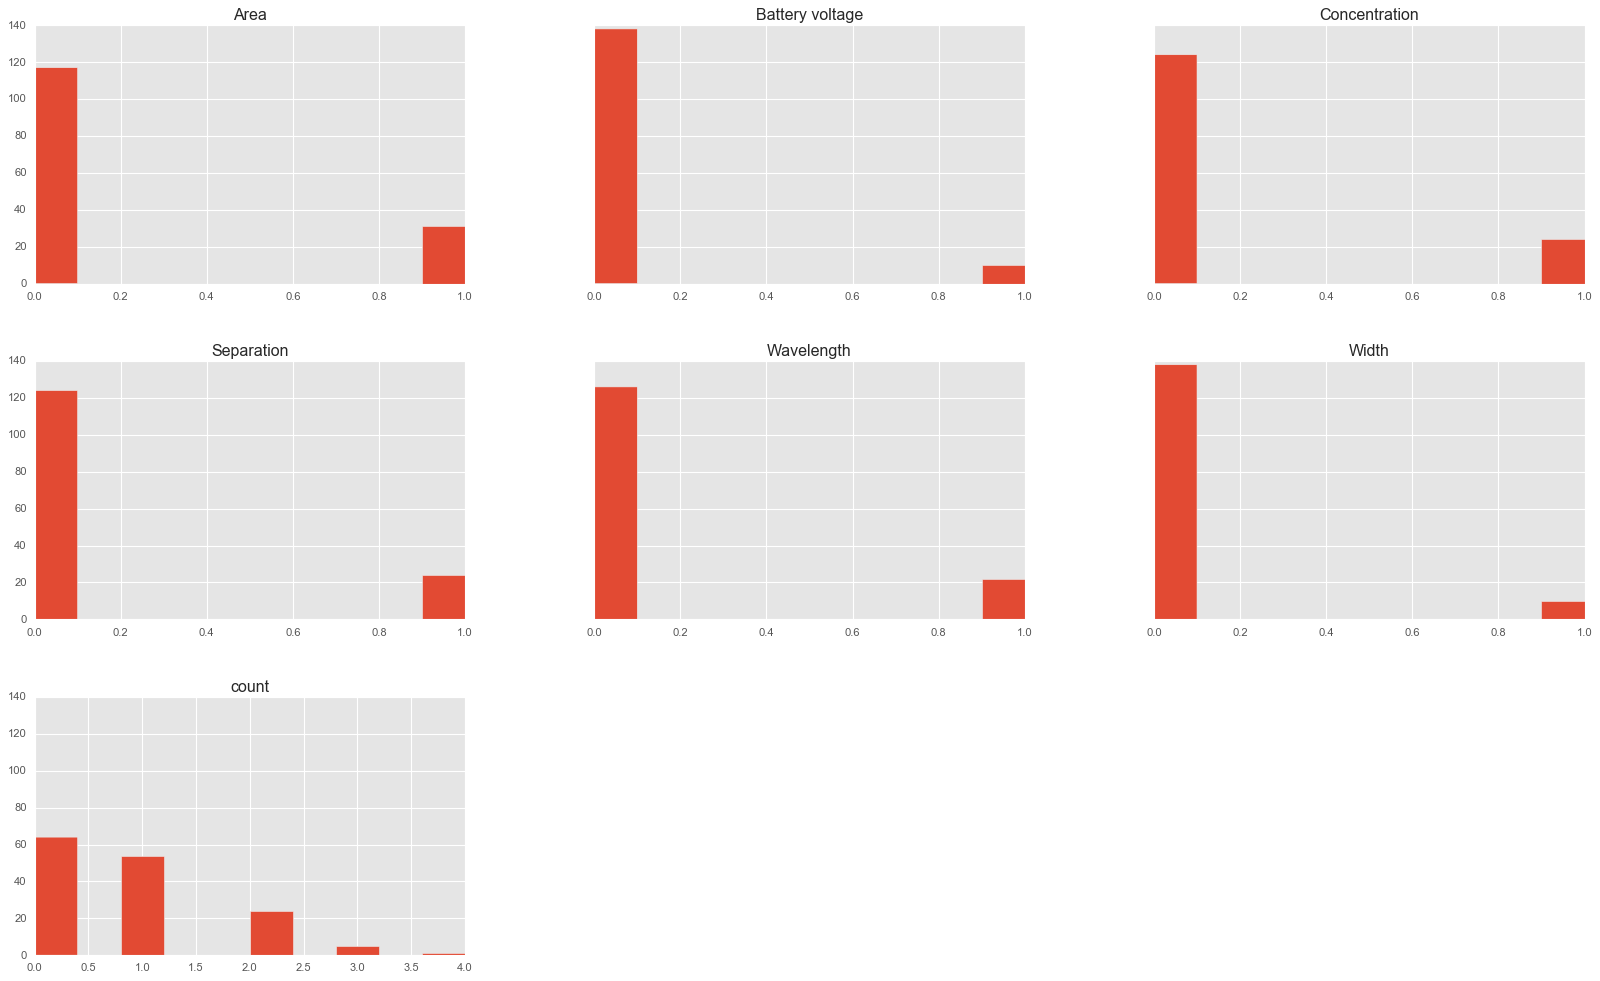

In [78]:
table_intervals_df.hist(sharey=True)